In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import librosa
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
# ==============================
# Load Dataset & Fix Shape Issue
# ==============================
def load_audio_data(data_dir, sr=22050, n_mfcc=13, fixed_width=260):
    audio_files = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Get label names

    print("🔄 Loading Dataset...")
    for class_label in tqdm(class_names, desc="Processing Classes"):  # Progress bar
        class_path = os.path.join(data_dir, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".wav") or file.endswith(".mp3"):
                    file_path = os.path.join(class_path, file)
                    y, _ = librosa.load(file_path, sr=sr)  # Load audio

                    # Compute MFCCs
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

                    # Normalize (optional but recommended)
                    # mfcc = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min())

                    # ==============================
                    # **Fix Shape: Pad or Crop to fixed_width**
                    # ==============================
                    if mfcc.shape[1] < fixed_width:
                        pad_width = fixed_width - mfcc.shape[1]
                        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                    else:
                        mfcc = mfcc[:, :fixed_width]  # Crop if too long

                    # mfcc = np.expand_dims(mfcc, axis=-1)  # Add channel dimension

                    audio_files.append(mfcc)
                    labels.append(class_label)

    print("✅ Dataset Loaded Successfully!")
    return np.array(audio_files), np.array(labels), class_names


In [ ]:
file_path = "/content/drive/MyDrive/IOT/SoundClasification/Dataset/Single/single_30.wav"

sr=22050
n_mfcc=13
fixed_width=260

y, _ = librosa.load(file_path, sr=sr)  # Load audio

# Compute MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

# Normalize (optional but recommended)
# mfcc = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min())

# ==============================
# **Fix Shape: Pad or Crop to fixed_width**
# ==============================
if mfcc.shape[1] < fixed_width:
    pad_width = fixed_width - mfcc.shape[1]
    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :fixed_width]  # Crop if too long

print(mfcc)
print(mfcc.shape)

[[-290.2745    -225.29907   -191.10349   ...    0.           0.
     0.       ]
 [ 139.15219    148.73938    118.25159   ...    0.           0.
     0.       ]
 [ -60.98297    -85.71878    -82.728226  ...    0.           0.
     0.       ]
 ...
 [ -14.682382   -15.355526   -10.849333  ...    0.           0.
     0.       ]
 [   5.0767555    5.8903704    4.159906  ...    0.           0.
     0.       ]
 [   5.6924744   10.436914    22.424313  ...    0.           0.
     0.       ]]
(13, 260)


In [ ]:
# ==============================
# CNN Patch Embedding Model
# ==============================
def build_cnn_patch_embedding(input_shape, embed_dim=256):
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(13, 260, 1)),  # Fix input shape (H, W, C)
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(8, activation='softmax')  # Adjust based on num_classes
    ])
    return model


In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load your dataset
data_dir = "/content/drive/MyDrive/IOT/SoundClasification/Dataset"
X, y, class_names = load_audio_data(data_dir)

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded_int = label_encoder.fit_transform(y)  # Integer-encoded labels
y_encoded = to_categorical(y_encoded_int)       # One-hot encoded labels

# 🔍 Print encoded label mapping
print("🔖 Encoded Label Mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {idx}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y)

# Build and train model
model = build_cnn_patch_embedding(input_shape=(13, 260, 1), embed_dim=256)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


🔄 Loading Dataset...


Processing Classes: 100%|██████████| 8/8 [03:12<00:00, 24.01s/it]

✅ Dataset Loaded Successfully!
🔖 Encoded Label Mapping:
Basin tap -> 0
Bathroom flush -> 1
Bird chirping -> 2
Child crying -> 3
Dog barking -> 4
Group -> 5
Single -> 6
Walker -> 7


NameError: name 'build_cnn_patch_embedding' is not defined

In [ ]:
data_dir = "/content/drive/MyDrive/IOT/SoundClasification/Dataset"  # Replace with your dataset path
X, y, class_names = load_audio_data(data_dir)

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels as integers

# One-hot encode labels
y_encoded = to_categorical(y_encoded)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


model = build_cnn_patch_embedding(input_shape=(13, 260, 1), embed_dim=256)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

🔄 Loading Dataset...


Processing Classes: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

✅ Dataset Loaded Successfully!
Epoch 1/20


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.2345 - loss: 13.5032 - val_accuracy: 0.5875 - val_loss: 1.9519
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6062 - loss: 1.2010 - val_accuracy: 0.7125 - val_loss: 0.7679
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8790 - loss: 0.4624 - val_accuracy: 0.8125 - val_loss: 0.5309
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9484 - loss: 0.1708 - val_accuracy: 0.8375 - val_loss: 0.4769
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9690 - loss: 0.0877 - val_accuracy: 0.8750 - val_loss: 0.5239
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9973 - loss: 0.0307 - val_accuracy: 0.8375 - val_loss: 0.5598
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9984 - loss: 0.0147 - val_accuracy: 0.8500 - val_loss: 0.4339
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9908 - loss: 0.0239 - val_accuracy: 0.8000 - val_loss: 

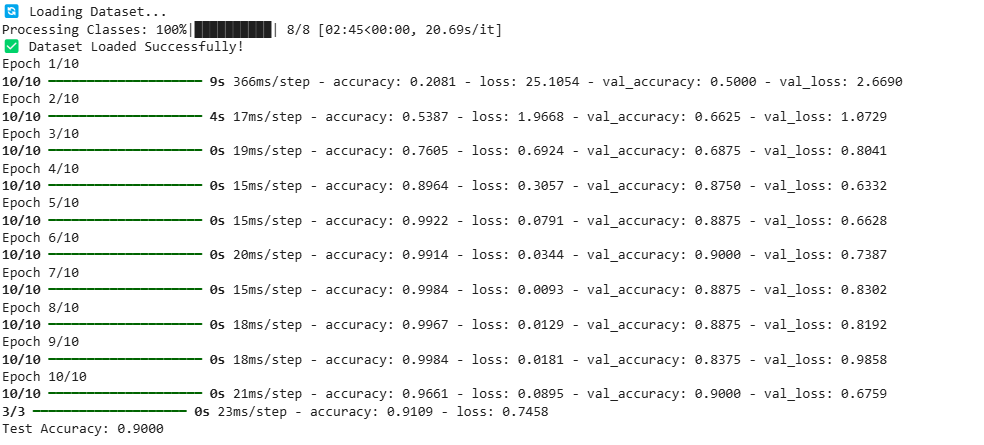

In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=e0fb2641d7fa9a6073858fb0db244abcc6333d9ab84aea86f5014dbe58c0d104
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


In [ ]:
import os
import numpy as np
from tqdm import tqdm
import scipy.io.wavfile as wav
from python_speech_features import mfcc

In [ ]:
def load_audio_data_psf(data_dir, sr=22050, n_mfcc=13, fixed_width=260):
    audio_files = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Get class/label names

    print("🔄 Loading Dataset...")
    for class_label in tqdm(class_names, desc="Processing Classes"):
        class_path = os.path.join(data_dir, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(class_path, file)

                    try:
                        rate, signal = wav.read(file_path)

                        # Optional: Resample if needed
                        if rate != sr:
                            from scipy.signal import resample
                            duration = len(signal) / rate
                            num_samples = int(duration * sr)
                            signal = resample(signal, num_samples)
                            rate = sr

                        # Step 2: Extract MFCCs
                        mfcc_feat = mfcc(signal, samplerate=rate, numcep=n_mfcc)

                        # Step 3: Transpose to get (13, num_frames)
                        mfcc_feat = mfcc_feat.T

                        # Step 4: Fix width (pad or truncate)
                        current_width = mfcc_feat.shape[1]
                        if current_width < fixed_width:
                            padding = np.zeros((n_mfcc, fixed_width - current_width))
                            mfcc_fixed = np.hstack((mfcc_feat, padding))
                        else:
                            mfcc_fixed = mfcc_feat[:, :fixed_width]

                        audio_files.append(mfcc_fixed)
                        labels.append(class_label)

                    except Exception as e:
                        print(f"❌ Error processing {file_path}: {e}")

    print("✅ Dataset Loaded Successfully!")
    return np.array(audio_files), np.array(labels), class_names


In [ ]:
data_dir = "/content/drive/MyDrive/IOT/SoundClasification/Dataset"
X, y, classes = load_audio_data_psf(data_dir, sr=16000, n_mfcc=13, fixed_width=260)

print("Data shape:", X.shape)   # e.g., (num_samples, 13, 260)
print("Labels shape:", y.shape)
print("Class names:", classes)


🔄 Loading Dataset...


Processing Classes: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]

✅ Dataset Loaded Successfully!
Data shape: (399, 13, 260)
Labels shape: (399,)
Class names: ['Basin tap', 'Bathroom flush', 'Bird chirping', 'Child crying', 'Dog barking', 'Group', 'Single', 'Walker']


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels as integers

# One-hot encode labels
y_encoded = to_categorical(y_encoded)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


model = build_cnn_patch_embedding(input_shape=(13, 260, 1), embed_dim=256)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.1854 - loss: 8.2847 - val_accuracy: 0.4375 - val_loss: 1.6309
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5671 - loss: 1.4249 - val_accuracy: 0.6750 - val_loss: 0.9703
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8009 - loss: 0.6895 - val_accuracy: 0.8250 - val_loss: 0.4578
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9274 - loss: 0.2589 - val_accuracy: 0.8875 - val_loss: 0.3443
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9760 - loss: 0.1208 - val_accuracy: 0.9375 - val_loss: 0.2300
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9994 - loss: 0.0342 - val_accuracy: 0.9125 - val_loss: 0.2022
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.9500 - val_loss: 0.1575
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9250 - 

In [ ]:
model.save('/content/drive/MyDrive/IOT/SoundClasification/model1.keras')


In [ ]:

import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('/content/drive/MyDrive/IOT/SoundClasification/model1.keras')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/IOT/SoundClasification/model1.tflite', 'wb') as f:
  f.write(tflite_model)


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from scipy.io import wavfile as wav
from scipy.signal import resample

def load_audio_amplitude_psf(data_dir, sr=22050, amp_width=57200):
    amplitudes = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Get class/label names

    print("🔄 Loading Dataset (Amplitude Only)...")
    for class_label in tqdm(class_names, desc="Processing Classes"):
        class_path = os.path.join(data_dir, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(class_path, file)

                    try:
                        rate, signal = wav.read(file_path)

                        # Optional: Resample if needed
                        if rate != sr:
                            duration = len(signal) / rate
                            num_samples = int(duration * sr)
                            signal = resample(signal, num_samples)
                            rate = sr

                        # Normalize amplitude [-1, 1] if signal is int type
                        if np.issubdtype(signal.dtype, np.integer):
                            signal = signal / np.iinfo(signal.dtype).max

                        # Fix amplitude length (pad or truncate)
                        if len(signal) < amp_width:
                            pad_signal = np.pad(signal, (0, amp_width - len(signal)), mode='constant')
                        else:
                            pad_signal = signal[:amp_width]

                        amplitudes.append(pad_signal)
                        labels.append(class_label)

                    except Exception as e:
                        print(f"❌ Error processing {file_path}: {e}")

    print("✅ Amplitude Dataset Loaded Successfully!")
    return np.array(amplitudes), np.array(labels), class_names


In [ ]:
data_dir = "/content/drive/MyDrive/IOT/SoundClasification/Dataset"
X, y, classes = load_audio_amplitude_psf(data_dir, sr=22050, amp_width=57200)

print("Data shape:", X.shape)   # e.g., (num_samples, 13, 260)
print("Labels shape:", y.shape)
print("Class names:", classes)

🔄 Loading Dataset (Amplitude Only)...


Processing Classes: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]

✅ Amplitude Dataset Loaded Successfully!
Data shape: (399, 57200)
Labels shape: (399,)
Class names: ['Basin tap', 'Bathroom flush', 'Bird chirping', 'Child crying', 'Dog barking', 'Group', 'Single', 'Walker']


In [ ]:
print(X.shape)

(399, 57200)


In [ ]:
def build_cnn_patch_embedding(input_shape=(57200,), embed_dim=256):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Reshape((57200, 1)),
        tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')  # 8 classes
    ])
    return model


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels as integers

# One-hot encode labels
y_encoded = to_categorical(y_encoded)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


model = build_cnn_patch_embedding(input_shape=(57200, 1), embed_dim=256)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1642 - loss: 33603.3047 - val_accuracy: 0.3125 - val_loss: 9938.5850
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.3869 - loss: 7618.6733 - val_accuracy: 0.4000 - val_loss: 2509.0779
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.5372 - loss: 835.5155 - val_accuracy: 0.3750 - val_loss: 1846.2054
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.6586 - loss: 457.8319 - val_accuracy: 0.3875 - val_loss: 844.9808
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.8524 - loss: 49.5394 - val_accuracy: 0.4500 - val_loss: 688.1385
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8768 - loss: 25.6408 - val_accuracy: 0.4625 - val_loss: 428.7208
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8818 - loss: 11.6867 - val_accuracy: 0.3625 - val_loss: 571.7406
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9388 - lo